# Importing libraries

In [62]:
import torch
from torch import nn
from torchrl.envs import (
    GymEnv,
    Compose,
    TransformedEnv,
    ToTensorImage,
    GrayScale,
    StepCounter,
    Resize,
    InitTracker,
    RewardScaling,
    ObservationNorm,
    set_exploration_type,
    ExplorationType
)
from tensordict.nn import TensorDictModule, TensorDictSequential
import matplotlib.pyplot as plt
from torchrl.modules import ConvNet, EGreedyModule, LSTMModule, MLP, QValueModule
from torchrl.objectives import DQNLoss, SoftUpdate
from torchrl.data import LazyMemmapStorage, TensorDictReplayBuffer
from torchrl.collectors import SyncDataCollector

import tqdm

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Selected device is {device}')

Selected device is cpu


# Environment

In [12]:
base_env = GymEnv(
    env_name='CartPole-v1', 
    from_pixels=True, 
    pixels_only=False,
    device=device
)
env = TransformedEnv(
    env=base_env,
    transform=Compose(
        ToTensorImage(),
        GrayScale(),
        Resize(84,84),
        StepCounter(),
        InitTracker(),
        RewardScaling(loc=0.0, scale=0.1),
        ObservationNorm(standard_normal=True, in_keys=['pixels'])
    )
)
env.transform[-1].init_stats(1000, reduce_dim=[0, 1, 2], cat_dim=0, keep_dims=[0])

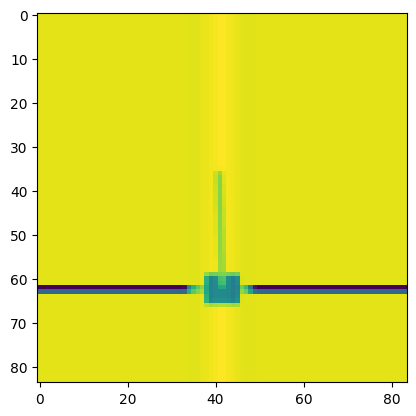

In [17]:
td = env.reset()
plt.imshow(td['pixels'].squeeze())

# Agent

In [21]:
feature = TensorDictModule(
    ConvNet(
        num_cells=[32, 32, 64],
        squeeze_output=True,
        aggregator_class=nn.AdaptiveAvgPool2d,
        aggregator_kwargs={"output_size": (1, 1)},
        device=device,
    ),
    in_keys=["pixels"],
    out_keys=["embed"],
)

In [27]:
n_cells = feature(env.reset())['embed'].shape[-1]

In [31]:
lstm = LSTMModule(
    input_size=n_cells,
    hidden_size=128,
    device=device,
    in_key='embed',
    out_key='embed'
)

In [ ]:
print('in_keys: '), lstm.out_keys

(['embed', 'recurrent_state_h', 'recurrent_state_c', 'is_init'],
 ['embed', ('next', 'recurrent_state_h'), ('next', 'recurrent_state_c')])

In [35]:
env.append_transform(lstm.make_tensordict_primer())

TransformedEnv(
    env=GymEnv(env=CartPole-v1, batch_size=torch.Size([]), device=cpu),
    transform=Compose(
            ToTensorImage(keys=['pixels']),
            GrayScale(keys=['pixels']),
            Resize(w=84, h=84, interpolation=InterpolationMode.BILINEAR, keys=['pixels']),
            StepCounter(keys=[]),
            InitTracker(keys=[]),
            RewardScaling(loc=0.0000, scale=0.1000, keys=['reward']),
            ObservationNorm(keys=['pixels']),
            TensorDictPrimer(primers=Composite(
                recurrent_state_h: UnboundedContinuous(
                    shape=torch.Size([1, 128]),
                    space=ContinuousBox(
                        low=Tensor(shape=torch.Size([1, 128]), device=cpu, dtype=torch.float32, contiguous=True),
                        high=Tensor(shape=torch.Size([1, 128]), device=cpu, dtype=torch.float32, contiguous=True)),
                    device=cpu,
                    dtype=torch.float32,
                    domain=continu

In [36]:
mlp = MLP(
    out_features=2,
    num_cells=[64,],
    device=device
)

In [38]:
mlp[-1].bias.data.fill_(0.0)

tensor([0., 0.])

In [39]:
mlp = TensorDictModule(
    module=mlp,
    in_keys=['embed'],
    out_keys=['action_value']
)

In [40]:
mlp

TensorDictModule(
    module=MLP(
      (0): LazyLinear(in_features=0, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=2, bias=True)
    ),
    device=cpu,
    in_keys=['embed'],
    out_keys=['action_value'])

In [ ]:
qval = QValueModule(action_space=None, spec=env.action_spec)

In [44]:
stoch_policy = TensorDictSequential(feature, lstm, mlp, qval)

In [46]:
exploration_module = EGreedyModule(
    annealing_num_steps=1_000_000, spec=env.action_spec, eps_init=0.2
)
stoch_policy = TensorDictSequential(
    stoch_policy,
    exploration_module,
)

In [47]:
policy = TensorDictSequential(feature, lstm.set_recurrent_mode(True), mlp, qval)

In [49]:
policy(env.reset())

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int64, is_shared=False),
        action_value: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        chosen_action_value: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        embed: Tensor(shape=torch.Size([128]), device=cpu, dtype=torch.float32, is_shared=False),
        is_init: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                recurrent_state_c: Tensor(shape=torch.Size([1, 128]), device=cpu, dtype=torch.float32, is_shared=False),
                recurrent_state_h: Tensor(shape=torch.Size([1, 128]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=cpu,
            is_shared=False),

In [51]:
loss_fn = DQNLoss(policy, action_space=env.action_spec, delay_value=True)

In [54]:
updater = SoftUpdate(loss_fn, eps=0.95)

In [55]:
optim = torch.optim.Adam(policy.parameters(), lr=3e-4)

In [64]:
collector = SyncDataCollector(env, stoch_policy, frames_per_batch=50, total_frames=200)
rb = TensorDictReplayBuffer(
    storage=LazyMemmapStorage(20_000), batch_size=4, prefetch=10
)

In [65]:
utd = 16
pbar = tqdm.tqdm(total=collector.total_frames)
longest = 0

traj_lens = []
for i, data in enumerate(collector):
    if i == 0:
        print(
            "Let us print the first batch of data.\nPay attention to the key names "
            "which will reflect what can be found in this data structure, in particular: "
            "the output of the QValueModule (action_values, action and chosen_action_value),"
            "the 'is_init' key that will tell us if a step is initial or not, and the "
            "recurrent_state keys.\n",
            data,
        )
    pbar.update(data.numel())
    # it is important to pass data that is not flattened
    rb.extend(data.unsqueeze(0).to_tensordict().cpu())
    for _ in range(utd):
        s = rb.sample().to(device, non_blocking=True)
        loss_vals = loss_fn(s)
        loss_vals["loss"].backward()
        optim.step()
        optim.zero_grad()
    longest = max(longest, data["step_count"].max().item())
    pbar.set_description(
        f"steps: {longest}, loss_val: {loss_vals['loss'].item(): 4.4f}, action_spread: {data['action'].sum(0)}"
    )
    exploration_module.step(data.numel())
    updater.step()

    with set_exploration_type(ExplorationType.DETERMINISTIC), torch.no_grad():
        rollout = env.rollout(10000, stoch_policy)
        traj_lens.append(rollout.get(("next", "step_count")).max().item())

  0%|          | 0/200 [00:00<?, ?it/s]

 25%|██▌       | 50/200 [00:01<00:03, 43.83it/s]

Let us print the first batch of data.
Pay attention to the key names which will reflect what can be found in this data structure, in particular: the output of the QValueModule (action_values, action and chosen_action_value),the 'is_init' key that will tell us if a step is initial or not, and the recurrent_state keys.
 TensorDict(
    fields={
        action: Tensor(shape=torch.Size([50, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        action_value: Tensor(shape=torch.Size([50, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        chosen_action_value: Tensor(shape=torch.Size([50, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([50]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([50]),
            device=None,
            is_shared=False),
        done: Tensor(shape=torch.Size([50, 1]), device=cpu, dtype=torch.bool, is

OSError: [WinError 1455] The paging file is too small for this operation to complete

 25%|██▌       | 50/200 [00:20<00:03, 43.83it/s]

In [60]:
if traj_lens:
    from matplotlib import pyplot as plt

    plt.plot(traj_lens)
    plt.xlabel("Test collection")
    plt.title("Test trajectory lengths")

NameError: name 'traj_lens' is not defined